# Deep Dive into US 26 at 92nd (Signal 2B100)
# Comparing 2025, 2024, and 2023 ODOT vs PSU pedestrian volumes
Use the Synapse full_ped export for 2025 (15-minute by phase) and PSU portal aggregates. Historical 2023 volumes come from the hourly ped_joined build created from the legacy parquet data.

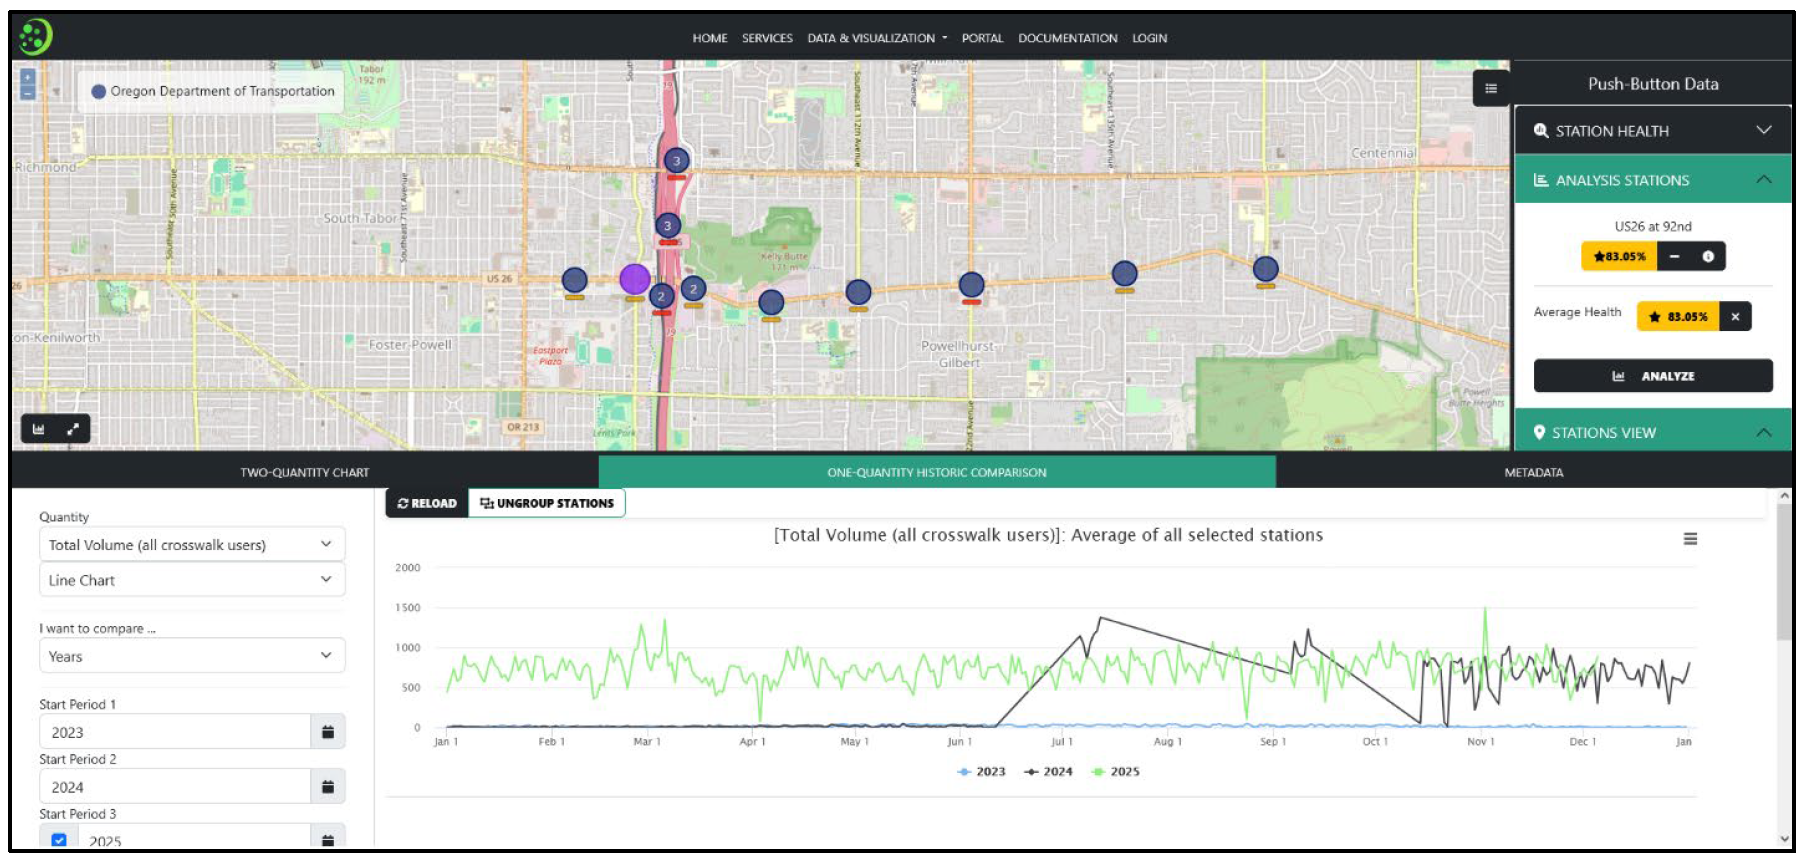

In [58]:

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import duckdb

# Keep plots viewable in notebooks without extra config
if not pio.renderers.default:
    pio.renderers.default = "notebook_connected"


## PSU portal aggregates

Load the PSU daily series once and reshape so both the comparison share the same day-of-year alignment.

Because PSU’s mid-year time shift pushed some timestamps late into the previous hour, `ceil` was used instead of `floor` so those shifted records landed in the intended hour. The highlighted rows below show the affected 23:00 timestamps:

![Time shift example 1](images/time_shift_1.png)
![Time shift example 2](images/time_shift_2.png)


In [62]:

psu = pd.read_csv("data/PSU_2B100.csv", parse_dates=["DateTime"])
psu["date"] = psu["DateTime"].dt.ceil("D")

psu_daily = (
    psu.melt(
        id_vars=["date"],
        value_vars=["2023", "2024", "2025"],
        var_name="year",
        value_name="PSU_Ped_Volumes",
    )
    .dropna(subset=["PSU_Ped_Volumes"])
    .assign(year=lambda df: df["year"].astype(int))
)
psu_daily["day_of_year"] = psu_daily["date"].dt.dayofyear

psu_2025 = psu_daily[psu_daily["year"] == 2025][["date", "day_of_year", "PSU_Ped_Volumes"]]
psu_2023 = psu_daily[psu_daily["year"] == 2023][["date", "day_of_year", "PSU_Ped_Volumes"]]

psu_daily.groupby("year")["PSU_Ped_Volumes"].count()


year
2023    354
2024    237
2025    334
Name: PSU_Ped_Volumes, dtype: int64

## 2025 Synapse export (15-minute, by phase)
Aggregate the full_ped table to daily totals across all phases for 2025, then align with PSU by day-of-year.

In [60]:

odot_15min = pd.read_csv("data/2B100_full_ped.csv", parse_dates=["TimeStamp"])
odot_15min["date"] = odot_15min["TimeStamp"].dt.floor("D")

odot_2025 = (
    odot_15min[odot_15min["date"].dt.year == 2025]
    .groupby("date", as_index=False)["Estimated_Volumes"]
    .sum()
    .rename(columns={"Estimated_Volumes": "ODOT_Ped_Volumes"})
)
odot_2025["day_of_year"] = odot_2025["date"].dt.dayofyear

odot_2025.head()


,date,ODOT_Ped_Volumes,day_of_year
0,2025-01-01,455.635699,1
1,2025-01-02,607.126402,2
2,2025-01-03,754.156604,3
3,2025-01-04,593.615001,4
4,2025-01-05,627.004799,5


## 2025 comparison
Align day-of-year so that PSU portal values (stored relative to 1970) line up with the real 2025 dates from the Synapse export.

In [63]:

comparison_2025 = (
    odot_2025.merge(
        psu_2025[["day_of_year", "PSU_Ped_Volumes"]],
        on="day_of_year",
        how="inner",
    )
    .assign(
        date_2025=lambda df: pd.to_datetime("2025-01-01")
        + pd.to_timedelta(df["day_of_year"] - 1, unit="D")
    )
    .sort_values("date_2025")
)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=comparison_2025["date_2025"],
        y=comparison_2025["ODOT_Ped_Volumes"],
        mode="lines+markers",
        name="ODOT Synapse 2025",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>ODOT: %{y:.2f}<extra></extra>",
    )
)
fig.add_trace(
    go.Scatter(
        x=comparison_2025["date_2025"],
        y=comparison_2025["PSU_Ped_Volumes"],
        mode="lines+markers",
        name="PSU 2025",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>PSU: %{y:.2f}<extra></extra>",
    )
)

fig.update_layout(
    title="2025 pedestrian volumes (Signal 2B100)",
    xaxis_title="Date",
    yaxis_title="Pedestrian volumes",
    hovermode="x unified",
    legend_title="Source",
)

fig.show()
comparison_2025.head()


,date,ODOT_Ped_Volumes,day_of_year,PSU_Ped_Volumes,date_2025
0,2025-01-01,455.635699,1,444.38,2025-01-01
1,2025-01-02,607.126402,2,592.76,2025-01-02
2,2025-01-03,754.156604,3,734.71,2025-01-03
3,2025-01-04,593.615001,4,580.90,2025-01-04
4,2025-01-05,627.004799,5,617.54,2025-01-05


Conclusion: The data track each other, with ODOT values being slightly higher. This is probably due to difference in calculation methodology. ODOT getting the volume estimates by applying an hourly rolling sum to the unique ped actuations, then applying the volume transformation, and then converting those hourly volumes back into 15-minute volumes. The exact process is here: https://github.com/ShawnStrasser/atspm/blob/main/src/atspm/queries/full_ped.sql

PSU is just using hourly volumes without any conversion. This may account for these slight differences.

## Historical 2023 volumes (ped_joined)
Build hourly volumes from the legacy parquet data (`Ped` + `Unique_Ped_Actuations`) with zero-filled gaps per phase, then aggregate to daily totals for 2023.

In [66]:
import pandas as pd
import duckdb

con = duckdb.connect()

ped_joined = con.sql("""
    SELECT *
    FROM '//scdata2/signalshar/data_analysis/Data/Performance/Ped/*.parquet'
    NATURAL INNER JOIN '//scdata2/signalshar/data_analysis/Data/Performance/Unique_Ped_Actuations/*.parquet'
    WHERE deviceid = 902
""").df()

ped_joined

,PedServices,PedActuation,TimeStamp,DeviceID,Phase,Unique_Actuations
0,1,2,2022-01-27 00:30:00,902,2,1
1,1,2,2022-01-27 00:30:00,902,8,1
2,1,1,2022-01-27 00:45:00,902,8,1
3,1,1,2022-01-27 01:00:00,902,2,1
4,1,1,2022-01-27 01:15:00,902,2,1
...,...,...,...,...,...,...
210308,3,6,2024-05-23 23:15:00,902,8,4
210309,2,2,2024-05-23 23:30:00,902,6,2
210310,3,4,2024-05-23 23:30:00,902,8,3
210311,2,7,2024-05-23 23:45:00,902,2,2


In [67]:
min_time = ped_joined["TimeStamp"].min().ceil("60min")
max_time = ped_joined["TimeStamp"].max().floor("60min")

time_range = pd.date_range(start=min_time, end=max_time, freq="60min")
phase_values = ped_joined["Phase"].unique()

time_range_df = pd.DataFrame(
    pd.MultiIndex.from_product([time_range, phase_values], names=["TimeStamp", "Phase"]).tolist(),
    columns=["TimeStamp", "Phase"],
)

hourly_ped = con.sql("""
    SELECT
        time_range_df.TimeStamp AS TimeStamp,
        time_range_df.Phase AS Phase,
        COALESCE(SUM(ped_joined.Unique_Actuations), 0) AS Unique_Actuations
    FROM time_range_df
    LEFT JOIN ped_joined
      ON time_range_df.TimeStamp = ped_joined.TimeStamp
     AND time_range_df.Phase = ped_joined.Phase
    GROUP BY time_range_df.TimeStamp, time_range_df.Phase
""").df()

ped_joined = con.sql("""
    SELECT
        TimeStamp,
        Phase,
        (0.7167 * Unique_Actuations + 0.0599 * Unique_Actuations * Unique_Actuations + 1.1063) AS Volumes
    FROM hourly_ped
    ORDER BY TimeStamp, Phase
""").df()

ped_joined["TimeStamp"] = pd.to_datetime(ped_joined["TimeStamp"])
ped_joined["TimeStamp"].agg(["min", "max"])


min   2022-01-01 01:00:00
max   2024-06-13 14:00:00
Name: TimeStamp, dtype: datetime64[ns]

## 2023 comparison
Aggregate the hourly volumes to daily totals, align by day-of-year with PSU 2023, and plot.

In [68]:

ped_joined["date"] = ped_joined["TimeStamp"].dt.floor("D")

odot_2023 = (
    ped_joined[ped_joined["date"].dt.year == 2023]
    .groupby("date", as_index=False)["Volumes"]
    .sum()
    .rename(columns={"Volumes": "ODOT_Ped_Volumes"})
)
odot_2023["day_of_year"] = odot_2023["date"].dt.dayofyear

comparison_2023 = (
    odot_2023.merge(
        psu_2023[["day_of_year", "PSU_Ped_Volumes"]],
        on="day_of_year",
        how="inner",
    )
    .assign(
        date_2023=lambda df: pd.to_datetime("2023-01-01")
        + pd.to_timedelta(df["day_of_year"] - 1, unit="D")
    )
    .sort_values("date_2023")
)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=comparison_2023["date_2023"],
        y=comparison_2023["ODOT_Ped_Volumes"],
        mode="lines+markers",
        name="ODOT historical 2023",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>ODOT: %{y:.2f}<extra></extra>",
    )
)
fig.add_trace(
    go.Scatter(
        x=comparison_2023["date_2023"],
        y=comparison_2023["PSU_Ped_Volumes"],
        mode="lines+markers",
        name="PSU 2023",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>PSU: %{y:.2f}<extra></extra>",
    )
)

fig.update_layout(
    title="Historical 2023 pedestrian volumes (Signal 2B100)",
    xaxis_title="Date",
    yaxis_title="Pedestrian volumes",
    hovermode="x unified",
    legend_title="Source",
)

fig.show()
comparison_2023.head()


,date,ODOT_Ped_Volumes,day_of_year,PSU_Ped_Volumes,date_2023
0,2023-01-01,200.0872,1,4.64,2023-01-01
1,2023-01-02,200.0210,2,1.88,2023-01-02
2,2023-01-03,258.0106,3,23.43,2023-01-03
3,2023-01-04,211.3232,4,4.64,2023-01-04
4,2023-01-05,238.3928,5,9.40,2023-01-05


## 2024 comparison (split ODOT sources)
Build ODOT 2024 daily totals by combining legacy `ped_joined` (through 2024-06-12) with the Synapse `full_ped` export (2024-06-14 onward). Drop the partial 2024-06-13 cutover day so PSU is only compared to complete ODOT days, then align everything by day-of-year.


In [ ]:
psu_2024 = psu_daily[psu_daily["year"] == 2024][["date", "day_of_year", "PSU_Ped_Volumes"]]

legacy_cutoff = pd.Timestamp("2024-06-13")

ped_joined["date"] = ped_joined["TimeStamp"].dt.floor("D")

odot_2024_legacy = (
    ped_joined[
        (ped_joined["date"].dt.year == 2024)
        & (ped_joined["date"] < legacy_cutoff)
    ]
    .groupby("date", as_index=False)["Volumes"]
    .sum()
    .rename(columns={"Volumes": "ODOT_Ped_Volumes"})
    .assign(source="Legacy ped_joined")
)

odot_2024_synapse = (
    odot_15min[odot_15min["date"].dt.year == 2024]
    .groupby("date", as_index=False)["Estimated_Volumes"]
    .sum()
    .rename(columns={"Estimated_Volumes": "ODOT_Ped_Volumes"})
    .assign(source="Synapse full_ped")
)

odot_2024 = (
    pd.concat([odot_2024_legacy, odot_2024_synapse], ignore_index=True)
    .assign(day_of_year=lambda df: df["date"].dt.dayofyear)
    .sort_values("date")
)

comparison_2024 = (
    odot_2024.merge(
        psu_2024[["day_of_year", "PSU_Ped_Volumes"]],
        on="day_of_year",
        how="inner",
    )
    .assign(
        date_2024=lambda df: pd.to_datetime("2024-01-01")
        + pd.to_timedelta(df["day_of_year"] - 1, unit="D")
    )
    .sort_values("date_2024")
)

fig = go.Figure()

for source_label in ["Legacy ped_joined", "Synapse full_ped"]:
    subset = comparison_2024[comparison_2024["source"] == source_label]
    if subset.empty:
        continue
    fig.add_trace(
        go.Scatter(
            x=subset["date_2024"],
            y=subset["ODOT_Ped_Volumes"],
            mode="lines+markers",
            name=f"ODOT 2024 ({source_label})",
            hovertemplate="Date: %{x|%Y-%m-%d}<br>ODOT: %{y:.2f}<extra></extra>",
        )
    )

fig.add_trace(
    go.Scatter(
        x=comparison_2024["date_2024"],
        y=comparison_2024["PSU_Ped_Volumes"],
        mode="lines+markers",
        name="PSU 2024",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>PSU: %{y:.2f}<extra></extra>",
    )
)

fig.update_layout(
    title="2024 pedestrian volumes (Signal 2B100)",
    xaxis_title="Date",
    yaxis_title="Pedestrian volumes",
    hovermode="x unified",
    legend_title="Source",
)

fig.show()
comparison_2024.head()
